<a href="https://colab.research.google.com/github/kashish049/Enhanced-Image-Style-Transfer/blob/main/Image_Style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Using device: cuda


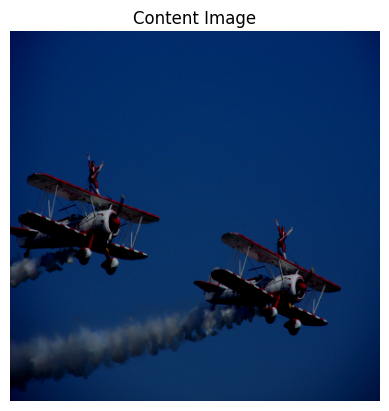

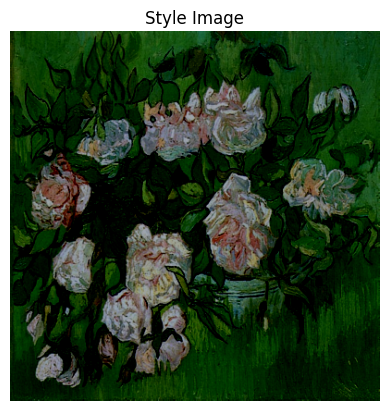

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 157MB/s]


Step [0/500], Total Loss: 1233.8910
Step [50/500], Total Loss: 525.1572
Step [100/500], Total Loss: 358.1671
Step [150/500], Total Loss: 134.3977
Step [200/500], Total Loss: 69.0494
Step [250/500], Total Loss: 45.2898
Step [300/500], Total Loss: 34.1110
Step [350/500], Total Loss: 28.0742
Step [400/500], Total Loss: 24.4504
Step [450/500], Total Loss: 22.1031


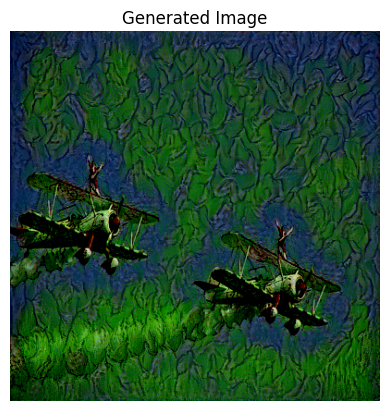

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load and preprocess images
def load_image(image_path, max_size=400):
    image = Image.open(image_path).convert('RGB')

    # Resize the image
    size = min(max(image.size), max_size)
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image.to(device)


# Display the generated image
def imshow(tensor, title=None):
    image = tensor.detach().cpu().clone().squeeze(0)  # Detach and move to CPU
    image = transforms.Normalize(
        mean=[-0.485, -0.456, -0.406],
        std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
    )(image)  # Unnormalize
    image = torch.clamp(image, 0, 1)  # Ensure values are in [0, 1]

    plt.imshow(image.permute(1, 2, 0))  # Convert to HWC format
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()


# Load the VGG19 model
class VGGFeatures(nn.Module):
    def __init__(self):
        super(VGGFeatures, self).__init__()
        self.vgg = models.vgg19(pretrained=True).features[:21]  # Extract layers
        for param in self.vgg.parameters():
            param.requires_grad = False  # Freeze VGG19 parameters

    def forward(self, x):
        features = []
        for layer in self.vgg:
            x = layer(x)
            if isinstance(layer, nn.ReLU):  # Save feature maps at ReLU layers
                features.append(x)
        return features

# Calculate the Gram matrix for style loss
def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    features = tensor.view(b * c, h * w)
    gram = torch.mm(features, features.t())  # Compute the Gram matrix
    return gram / (b * c * h * w)

# Define content and style loss functions
def content_loss(gen_features, content_features):
    return torch.mean((gen_features - content_features) ** 2)

def style_loss(gen_features, style_grams):
    style_loss = 0
    for gf, sg in zip(gen_features, style_grams):
        gram_gen = gram_matrix(gf)
        style_loss += torch.mean((gram_gen - sg) ** 2)
    return style_loss

# Perform style transfer
def style_transfer(content_img, style_img, num_steps=500, style_weight=1e6, content_weight=1e0):
    generated_img = content_img.clone().requires_grad_(True).to(device)
    optimizer = optim.Adam([generated_img], lr=0.01)
    vgg = VGGFeatures().to(device)

    # Extract style and content features
    content_features = vgg(content_img)
    style_features = vgg(style_img)
    style_grams = [gram_matrix(f) for f in style_features]

    for step in range(num_steps):
        optimizer.zero_grad()

        gen_features = vgg(generated_img)
        c_loss = content_loss(gen_features[-1], content_features[-1])
        s_loss = style_loss(gen_features, style_grams)

        total_loss = content_weight * c_loss + style_weight * s_loss
        total_loss.backward()
        optimizer.step()

        if step % 50 == 0:
            print(f"Step [{step}/{num_steps}], Total Loss: {total_loss.item():.4f}")

    return generated_img

# Example usage
content_path ="/content/drive/MyDrive/image2/000000046608.jpg"
style_path = "/content/drive/MyDrive/1890(1)/206942.jpg"

content_img = load_image(content_path)
style_img = load_image(style_path)

imshow(content_img, "Content Image")
imshow(style_img, "Style Image")

generated_img = style_transfer(content_img, style_img)
imshow(generated_img, "Generated Image")



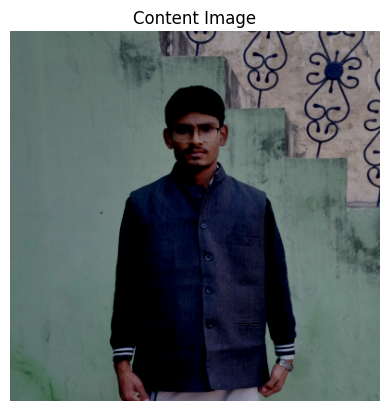

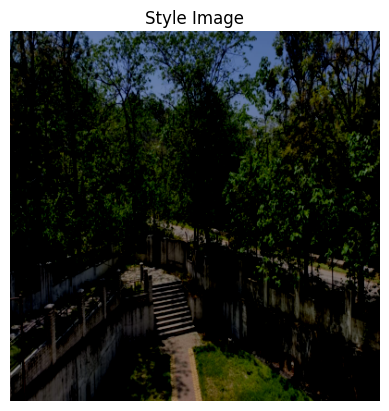

Step [0/500], Total Loss: 539.1494
Step [50/500], Total Loss: 72.4954
Step [100/500], Total Loss: 45.3280
Step [150/500], Total Loss: 36.1307
Step [200/500], Total Loss: 30.7458
Step [250/500], Total Loss: 27.0070
Step [300/500], Total Loss: 24.2318
Step [350/500], Total Loss: 22.0992
Step [400/500], Total Loss: 20.4262
Step [450/500], Total Loss: 19.0962


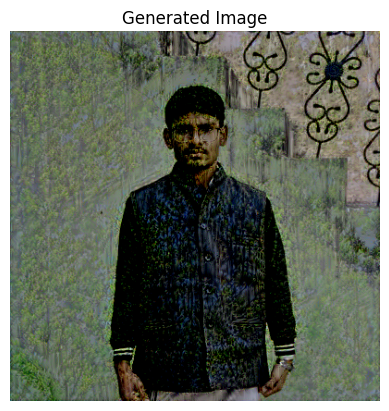

In [4]:
content_path ="Me.jpg"
style_path = "Style.jpg"

content_img = load_image(content_path)
style_img = load_image(style_path)

imshow(content_img, "Content Image")
imshow(style_img, "Style Image")

generated_img = style_transfer(content_img, style_img)
imshow(generated_img, "Generated Image")

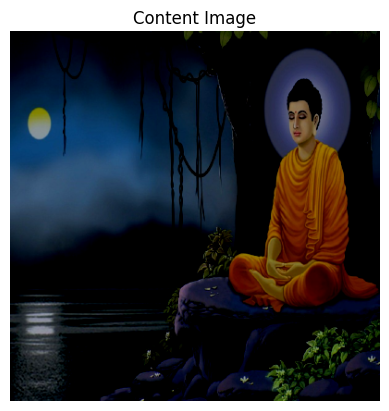

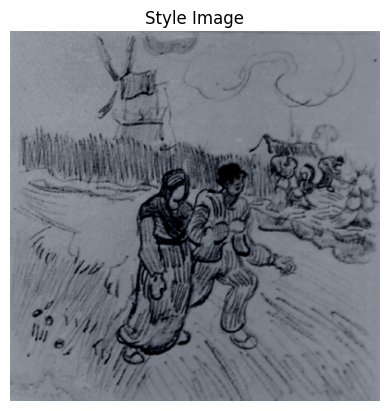

Step [0/500], Total Loss: 362.3083
Step [50/500], Total Loss: 43.6997
Step [100/500], Total Loss: 32.5381
Step [150/500], Total Loss: 28.3078
Step [200/500], Total Loss: 25.8082
Step [250/500], Total Loss: 24.0662
Step [300/500], Total Loss: 22.7530
Step [350/500], Total Loss: 21.7017
Step [400/500], Total Loss: 20.8347
Step [450/500], Total Loss: 20.0956


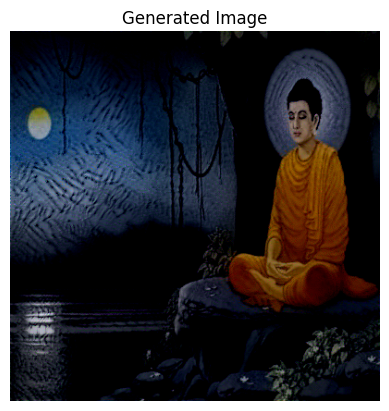

In [ ]:
content_path ="budha.jpg"
style_path = "/content/drive/MyDrive/1890(1)/205831.jpg"

content_img = load_image(content_path)
style_img = load_image(style_path)

imshow(content_img, "Content Image")
imshow(style_img, "Style Image")

generated_img = style_transfer(content_img, style_img)
imshow(generated_img, "Generated Image")